In [1]:
import numpy.typing as npt
import numpy as np
from typing import Union
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

# own module
from simulations.fractional_brownian import (
    generate_brownian_path,
    generate_n_assets_portfolio,
)
from backtest.backtester import Backtester
from strategy.strategy import SalopekStrategy

from utility.utils import generate_t, a_order_power_mean, transaction_cost_L

In [2]:
t, s_t = generate_brownian_path(
    n_steps=250, T=1, H=0.8, mu=0.15, sigma=0.2, s0=100, brownian_type="fractional"
)

Price process : $$s^i_t=s^i_0\times e^{\mu^it+\sigma^iB_t^{H^i}}$$


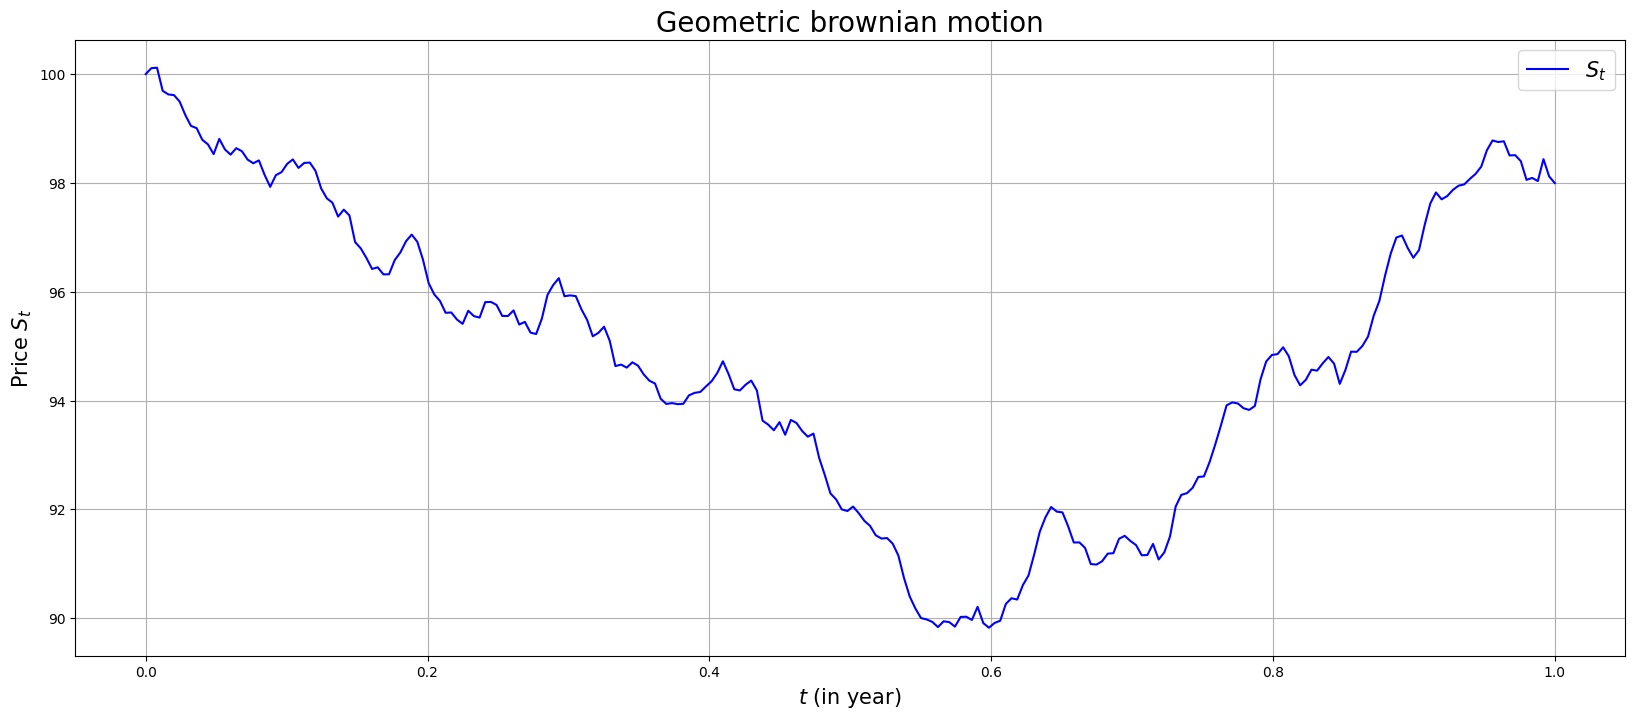

In [3]:
_, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.plot(
    t,
    s_t,
    color="blue",
    label="$S_t$",
)

ax.set_xlabel("$t$ (in year)", fontsize=15)
ax.set_ylabel("Price $S_t$", fontsize=15)
ax.set_title(f"Geometric brownian motion", fontsize=20)
ax.grid()
ax.legend(fontsize=15)

- Portfolio value at time $t$ : $$V^\Psi_t=\sum^d_{i=0}\Psi_t^iS_t^i$$
- Gain process at time $t$ : $$G^\Psi_t=\sum^d_{i=0}\int_0^t\Psi_t^idS_t^i$$
- Portfolio value at time $t$ : $$V^\Psi_t=\nu+G^\Psi_t$$


# Salopek strategy

Another arbitrage strategy, dating back to Harrison et al. (1984) and applied in a fractional Black-Scholes market by Salopek (1998), trades $d \geq 2$ risky assets and ignores the risk-free asset. It is defined for two real-valued constants $\alpha<\beta$ and can be summarized as $\Psi=(0, \Psi(\alpha, \beta))$ or, with some abuse of notation, $\Psi=\Psi(\alpha, \beta)$. The entries of $\Psi(\alpha, \beta)=\left(\Psi_{t}^{1}(\alpha, \beta), \ldots, \Psi_{t}^{d}(\alpha, \beta)\right)$ are the risky asset shares at time $t \in[0, T]$. Specifically, for $i=1, \ldots, d$, we have

$$
\begin{equation*}
\Psi_{t}^{i}(\alpha, \beta)=\widehat{\Psi}_{t}^{i}(\beta)-\widehat{\Psi}_{t}^{i}(\alpha), \quad \text { where } \quad \widehat{\Psi}_{t}^{i}(a)=\frac{1}{d}\left(\frac{S_{t}^{i}}{M_{a}\left(S_{t}\right)}\right)^{a-1} \tag{2.10}
\end{equation*}
$$

$M_{a}(x)$ denotes the $a$-order power mean of $x=\left(x^{1}, \ldots, x^{d}\right) \in \mathbb{R}_{+}^{d}$. It is given by

$$
\begin{array}{ll}
M_{a}(x)=\left(\frac{1}{d} \sum_{i=1}^{d}\left(x^{i}\right)^{a}\right)^{1 / a} \quad \text { for } \quad a \neq 0  \tag{2.11}\\
M_{0}(x)=\sqrt[d]{x^{1} \cdot \ldots \cdot x^{d}} \quad \text { for } \quad a=0
\end{array}
$$

Remark 2.2 With respect to the properties of the a-order power mean, we can list the following important special cases:

$$
\begin{aligned}
& M_{1}(x)=\left(x^{1}+\ldots+x^{d}\right) / d \quad \text { (arithmetic mean) } \\
& M_{2}(x)=\sqrt{\left(\left(x^{1}\right)^{2}+\ldots+\left(x^{d}\right)^{2}\right) / d} \quad \text { (quadratic mean) } \\
& M_{-1}(x)=\left(\left(1 / x^{1}+\ldots+1 / x^{d}\right) / d\right)^{-1} \quad \text { (harmonic mean) } \\
& M_{0}(x)=\sqrt[d]{x^{1} \cdot \ldots \cdot x^{d}}=\lim _{a \rightarrow 0} M_{a}(x) \quad \text { (geometric mean) } \\
& M_{\infty}(x):=\lim _{a \rightarrow+\infty} M_{a}(x)=x_{\max }=\max \left\{x^{1}, \ldots, x^{d}\right\} \quad(\text { maximum of } x) \\
& M_{-\infty}(x):=\lim _{a \rightarrow-\infty} M_{a}(x)=x_{\min }=\min \left\{x^{1}, \ldots, x^{d}\right\} \quad(\text { minimum of } x)
\end{aligned}
$$

The strategy $\Psi(\alpha, \beta)$ in (2.10) is expressed as the difference between $\widehat{\Psi}(\beta)$ and $\widehat{\Psi}(\alpha)$. Because these two components can be considered as strategies themselves, we call $\widehat{\Psi}(a)$ an a-strategy or a-portfolio. Consequently, an investor can implement $\Psi(\alpha, \beta)$ by purchasing a $\beta$-portfolio and short-selling an $\alpha$-portfolio.

Substituting the $\widehat{\Psi}(a)$ specified by (2.10) into (2.5) provides the portfolio value of an $a$-strategy, i.e., we obtain

$$
\begin{equation*}
V_{t}^{\widehat{\Psi}(a)}=M_{a}\left(S_{t}\right) . \tag{2.13}
\end{equation*}
$$


In [4]:
df_ptf = generate_n_assets_portfolio(
    2,
    n_steps=250,
    T=1,
    H=0.7,
    mu=0.05,
    sigma=0.1,
    s0=100,
    add_risk_free_asset=False,
    as_dataframe=True,
    brownian_type="fractional",
)
df_ptf

generate all paths of the portfolio:   0%|          | 0/2 [00:00<?, ?it/s]

,S_1_t,S_2_t
0.000000,100.000000,100.000000
0.004016,99.823387,99.994596
0.008032,99.730866,100.410084
0.012048,99.735961,100.820405
0.016064,99.679803,101.011520
...,...,...
0.983936,129.742950,134.991125
0.987952,129.708675,135.132176
0.991968,130.328083,135.351785
0.995984,130.459434,134.944603


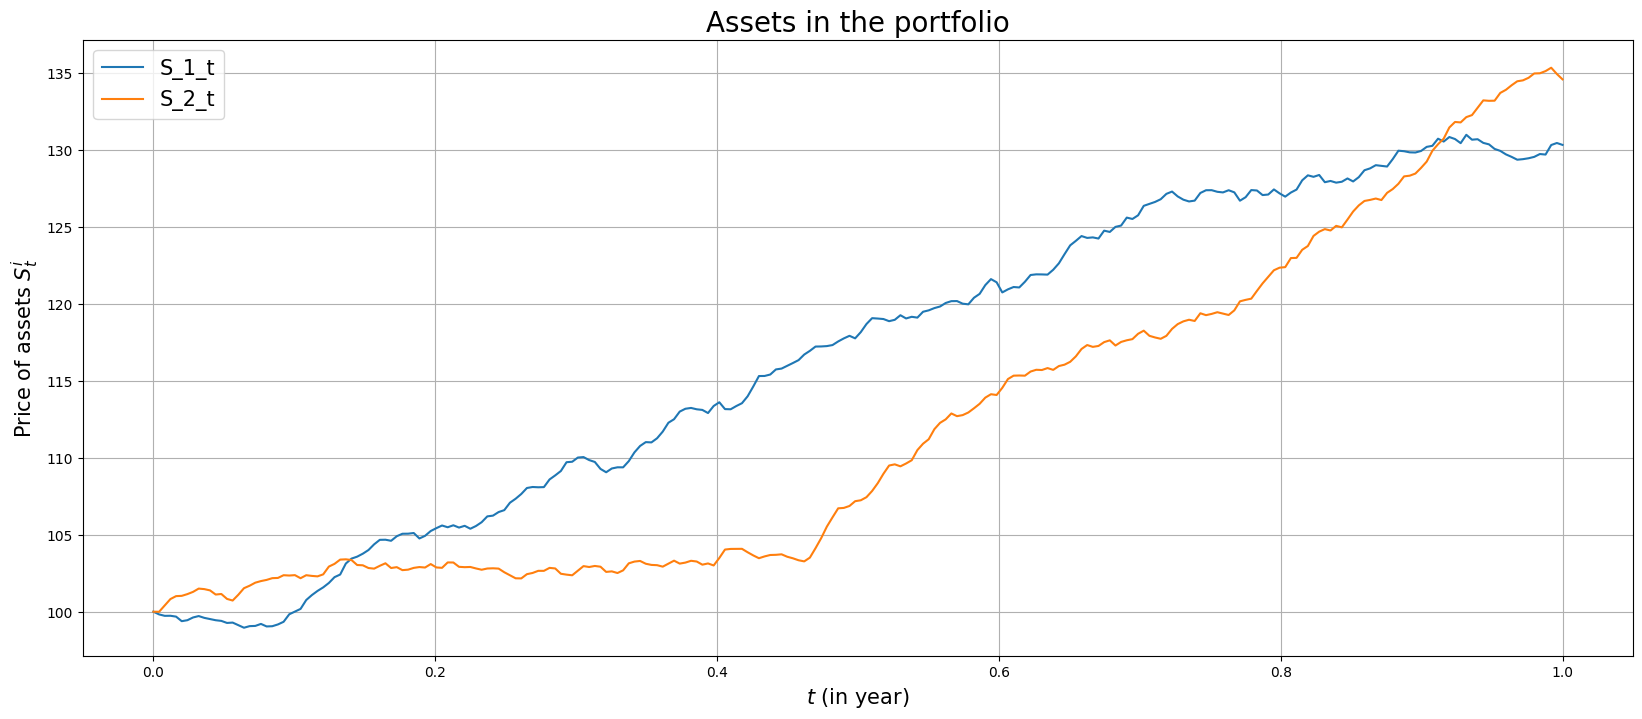

In [5]:
_, ax = plt.subplots(1, 1, figsize=(20, 8))
for col in df_ptf.columns:
    ax.plot(
        df_ptf[col],
        label=f"{col}",
    )

ax.set_xlabel("$t$ (in year)", fontsize=15)
ax.set_ylabel("Price of assets $S_t^i$", fontsize=15)
ax.set_title(f"Assets in the portfolio", fontsize=20)
ax.grid()
ax.legend(fontsize=15)

$$\Psi_t^i(a)=\frac{1}{d}\times(\frac{S_t^i}{M_a(S_t)})^{a-1}$$
and $$\Phi_n^i=\Psi_{t-1}^i \quad i=1,...,d$$


Transaction cost : $$L_t^\Phi=l(\Gamma_t^\Phi,p) \quad \text { with } \quad l(y,p)=max(p_1y,p_2)\mathbb{1}_{\{y>0\}}$$
And $p=(p_1,p_2)$

Liquidation :

$$R^\Phi=\sum_{i=0}^d\Phi_N^iS_T^i-L^\Phi_T$$


# Running the strategy

## Salopek


In [6]:
ALPHA = -30
BETA = 30

# fees (no fees now)
P1 = 0  # 0.1 proportionality factor p1 (in percent)
P2 = 0  # 0.5 minimum fee p2 (in monetary units)

SCALING_FACTOR = 100  # \gamma

salopek_strat = SalopekStrategy(alpha=ALPHA, beta=BETA, scaling_factor=SCALING_FACTOR)

bk_tester = Backtester()

weights_df, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
    universe_dataframe=df_ptf,
    allocation_function=salopek_strat.get_allocation,
    p1=P1,
    p2=P2,
)

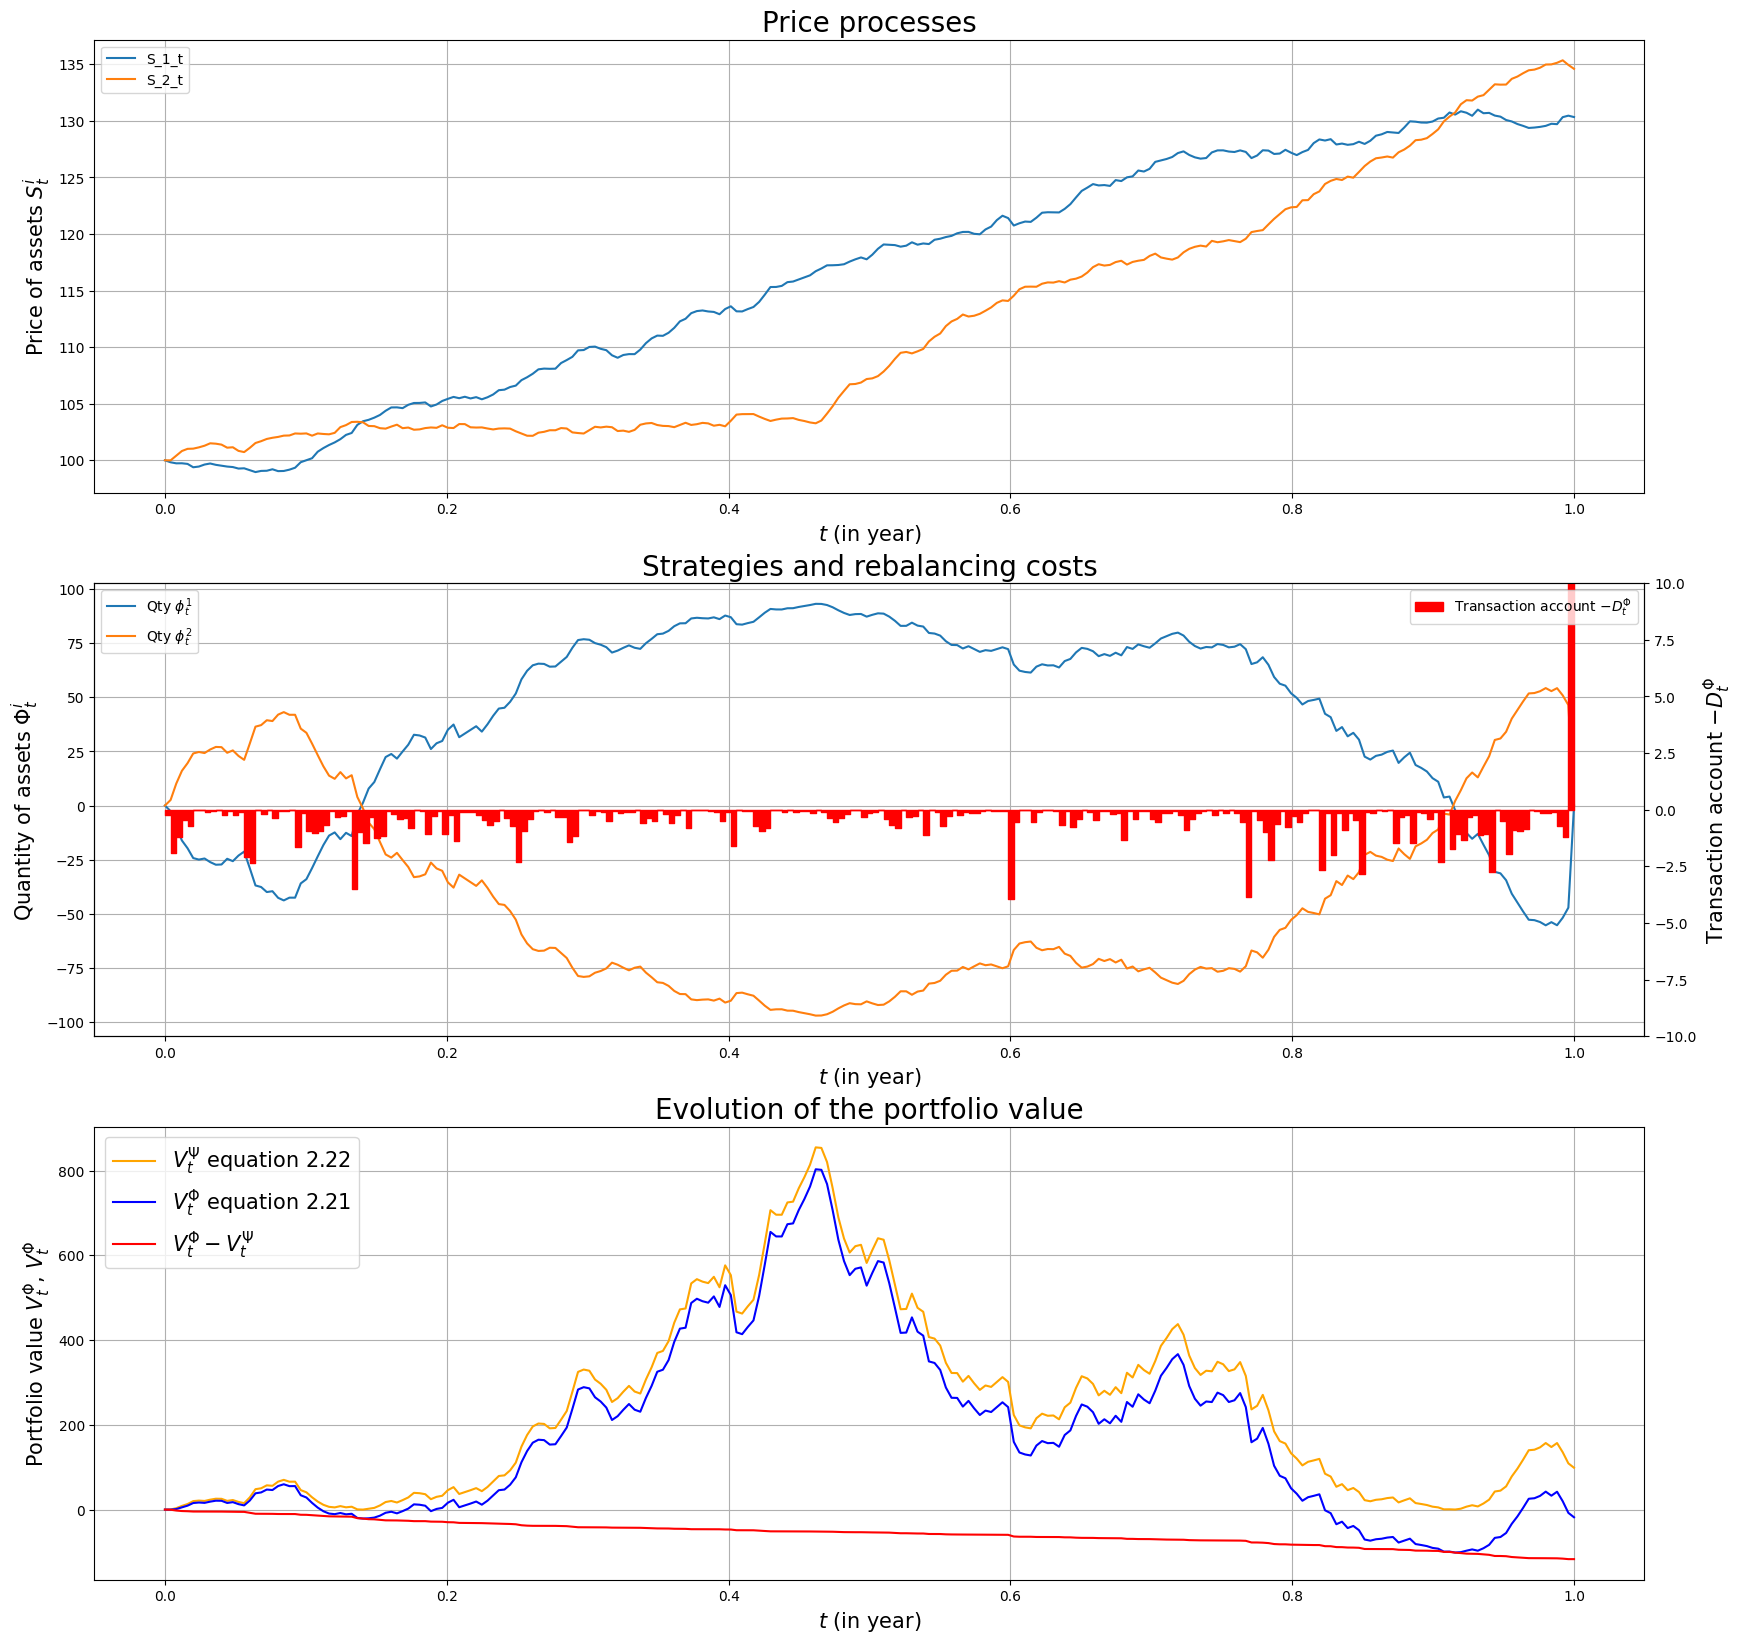

In [7]:
_, ax = plt.subplots(3, 1, figsize=(20, 20))
for col in df_ptf.columns:
    ax[0].plot(
        df_ptf[col],
        label=f"{col}",
    )

ax[0].set_xlabel("$t$ (in year)", fontsize=15)
ax[0].set_ylabel("Price of assets $S_t^i$", fontsize=15)
ax[0].set_title(f"Price processes", fontsize=20)
ax[0].grid()
ax[0].legend(fontsize=10)

for col in weights_df.columns:
    ax[1].plot(
        weights_df[col],
        label=r"Qty $\{}_t$".format(col.replace("_", "^")),
    )
ax_l = ax[1].twinx()
ax_l.fill_between(
    df_ptf.index,
    -transaction_account,
    color="red",
    step="pre",
    label=r"Transaction account $-D_t^\Phi$",
)

ax[1].set_xlabel("$t$ (in year)", fontsize=15)
ax[1].set_ylabel(r"Quantity of assets $\Phi_t^i$", fontsize=15)
ax_l.set_ylabel(r"Transaction account $-D_t^\Phi$", fontsize=15)
ax_l.set_ylim([-10, 10])
ax[1].set_title(f"Strategies and rebalancing costs", fontsize=20)
ax[1].grid()
ax[1].legend(fontsize=10, loc="upper left")
ax_l.legend(fontsize=10, loc="upper right")
# ax_l2 = ax[2].twinx()
ax[2].plot(df_ptf.index, V_t_psi, label=r"$V_t^\Psi$ equation 2.22", color="orange")
ax[2].plot(
    df_ptf.index,
    V_t_phi,
    # linestyle="--",
    label=r"$V_t^\Phi$ equation 2.21",
    color="blue",
)
ax[2].plot(
    df_ptf.index,
    V_t_phi - V_t_psi,
    label=r"$V_t^\Phi-V_t^\Psi$",
    color="red",
)

ax[2].set_xlabel("$t$ (in year)", fontsize=15)
ax[2].set_ylabel(r"Portfolio value $V_t^\Phi$, $V_t^\Phi$", fontsize=15)
ax[2].set_title(f"Evolution of the portfolio value", fontsize=20)
ax[2].grid()
# ax_l2.legend(fontsize=15, loc="upper left")
ax[2].legend(fontsize=15, loc="upper left")

# Monte carlo simulation


In [8]:
N_SIMULATION = 10

ALPHA = -30
BETA = 30

# fees (no fees now)
P1 = 0  # 0.1 proportionality factor p1 (in percent)
P2 = 0  # 0.5 minimum fee p2 (in monetary units)

SCALING_FACTOR = 100  # \gamma


salopek_strat = SalopekStrategy(alpha=ALPHA, beta=BETA)
bk_tester = Backtester()

all_V_t_psi = []
all_V_t_phi = []
all_transaction_account = []

for _ in tqdm(
    range(N_SIMULATION),
    leave=False,
    desc="Computing MC simulation...",
    total=N_SIMULATION,
):
    df_ptf = generate_n_assets_portfolio(
        n_assets=2,
        n_steps=250,
        T=1,
        H=0.7,
        mu=0.05,
        sigma=0.1,
        s0=100,
        add_risk_free_asset=False,
        as_dataframe=True,
        brownian_type="fractional",
    ).drop(0)
    _, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
        universe_dataframe=df_ptf,
        allocation_function=salopek_strat.get_allocation,
        p1=P1,
        p2=P2,
    )
    all_V_t_psi.append(V_t_psi)
    all_V_t_phi.append(V_t_phi)
    all_transaction_account.append(transaction_account)
    del df_ptf

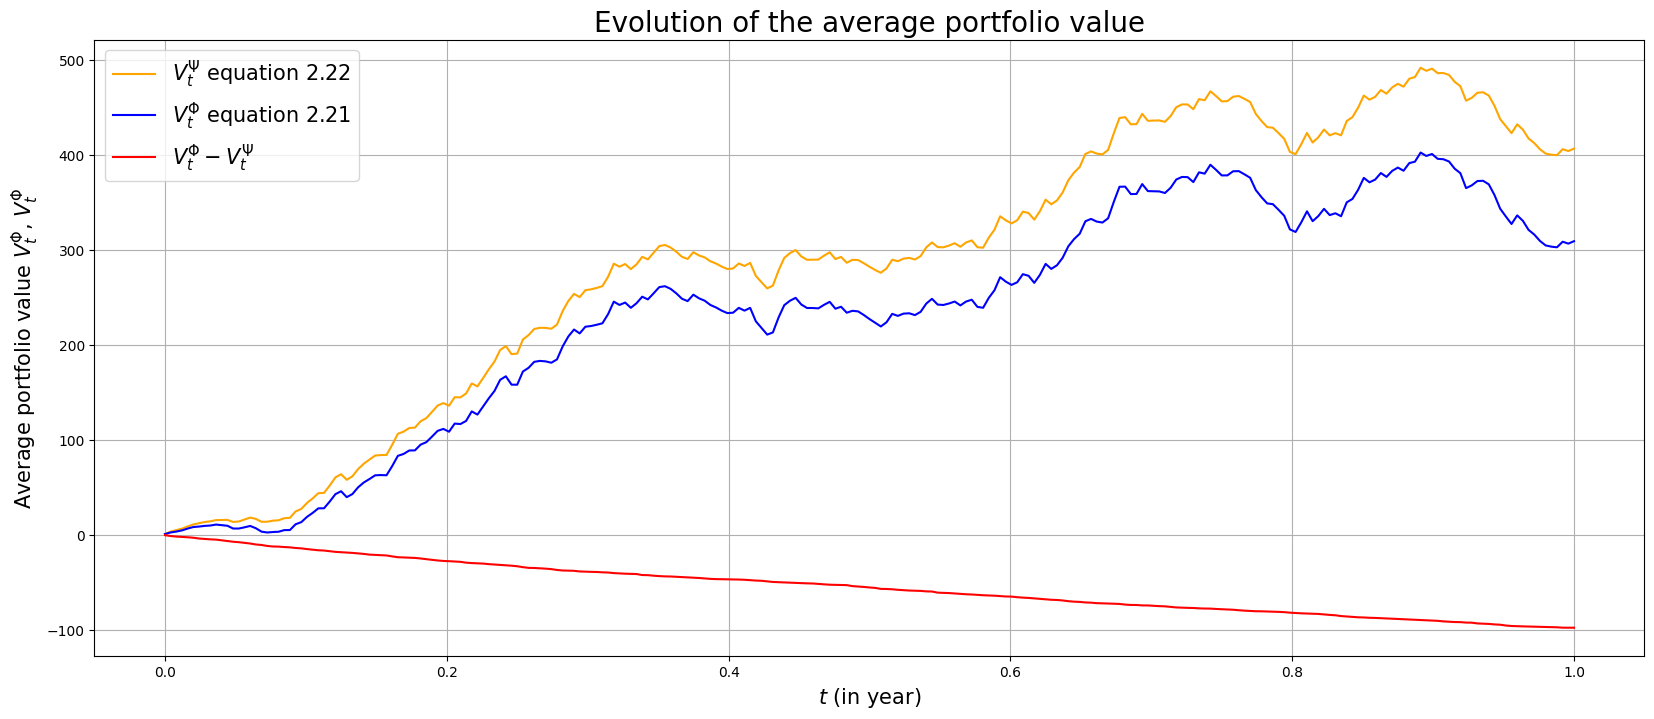

In [9]:
_, ax = plt.subplots(1, 1, figsize=(20, 8))
t = generate_t(249, 1)
ax.plot(
    t, np.mean(all_V_t_psi, axis=0), label=r"$V_t^\Psi$ equation 2.22", color="orange"
)
ax.plot(
    t,
    np.mean(all_V_t_phi, axis=0),
    # linestyle="--",
    label=r"$V_t^\Phi$ equation 2.21",
    color="blue",
)
ax.plot(
    t,
    np.mean(all_V_t_phi, axis=0) - np.mean(all_V_t_psi, axis=0),
    label=r"$V_t^\Phi-V_t^\Psi$",
    color="red",
)

ax.set_xlabel("$t$ (in year)", fontsize=15)
ax.set_ylabel(r"Average portfolio value $V_t^\Phi$, $V_t^\Phi$", fontsize=15)
ax.set_title(f"Evolution of the average portfolio value", fontsize=20)
ax.grid()
# ax_l2.legend(fontsize=15, loc="upper left")
ax.legend(fontsize=15, loc="upper left")

# Real data


,ENGI FP Equity,CS FP Equity
Date,,
2006-01-30,26.100,26.7691
2006-01-31,26.010,26.7403
2006-02-01,26.370,26.9703
2006-02-02,26.400,26.5295
2006-02-03,26.560,26.4240
...,...,...
2024-04-23,16.015,34.9200
2024-04-24,16.085,34.2500
2024-04-25,16.080,33.8000


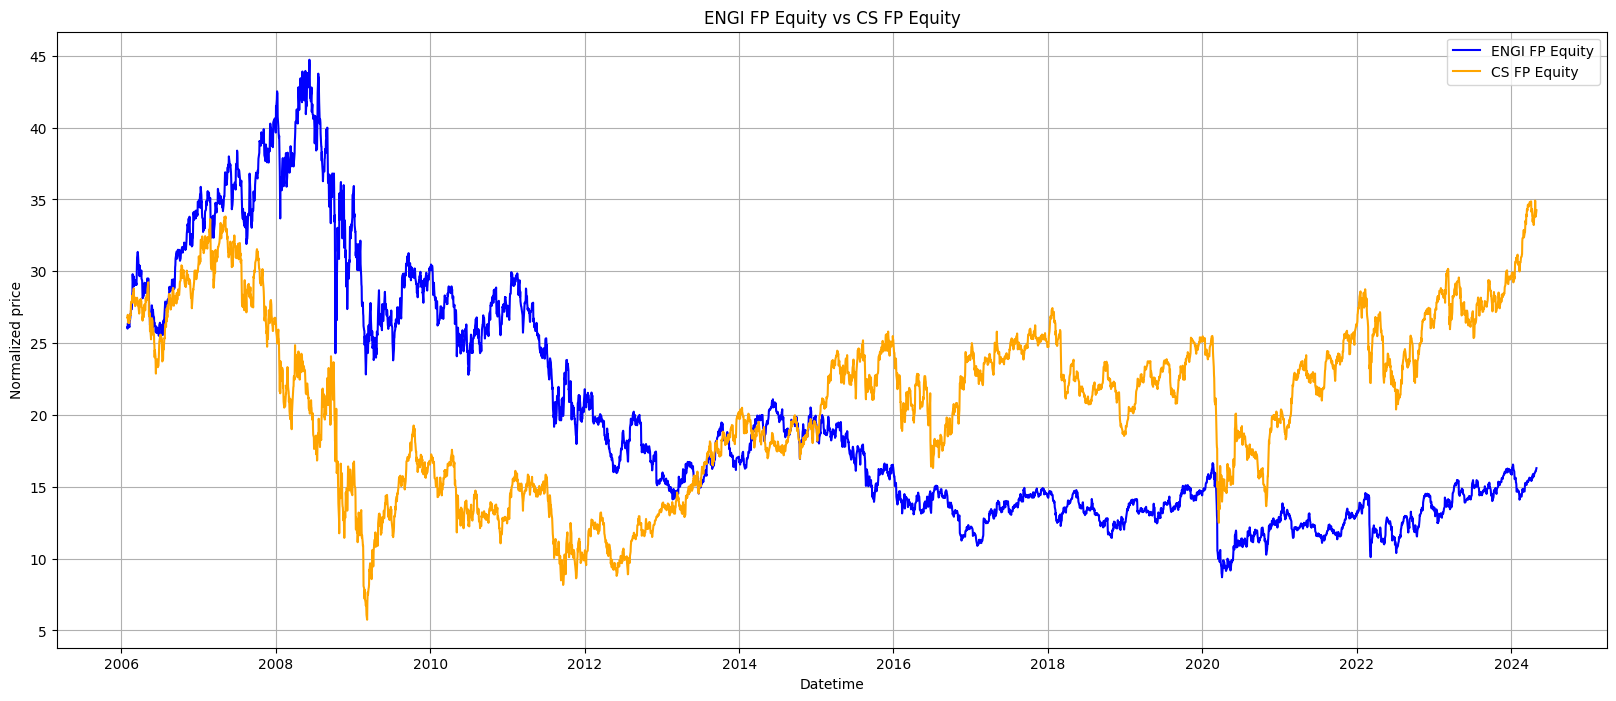

In [19]:
df_ptf = pd.read_csv("../data/data_engie_axa.csv", sep=",").ffill()
df_ptf["Date"] = pd.to_datetime(df_ptf["Date"])
df_ptf = df_ptf.set_index("Date").sort_index()#.loc["2020-03-01":]
#df_ptf = (df_ptf.pct_change().fillna(99) + 1).cumprod()#.loc["2020-01-01":]

plt.figure(figsize=(20, 8))
plt.plot(df_ptf["ENGI FP Equity"], label="ENGI FP Equity", color="blue")
plt.plot(df_ptf["CS FP Equity"], label="CS FP Equity", color="orange")
plt.xlabel("Datetime")
plt.ylabel("Normalized price")
plt.title("ENGI FP Equity vs CS FP Equity")
plt.grid()
plt.legend()

df_ptf

In [20]:
ALPHA = -30
BETA = 30

# fees (no fees now)
P1 = 0.1  # 0.1 proportionality factor p1 (in percent)
P2 = 0.5  # 0.5 minimum fee p2 (in monetary units)

SCALING_FACTOR = 100  # \gamma


salopek_strat = SalopekStrategy(alpha=ALPHA, beta=BETA)


bk_tester = Backtester()

weights_df, V_t_psi, V_t_phi, transaction_account = bk_tester.run_backtest(
    universe_dataframe=df_ptf,
    allocation_function=salopek_strat.get_allocation,
    p1=P1,
    p2=P2,
)

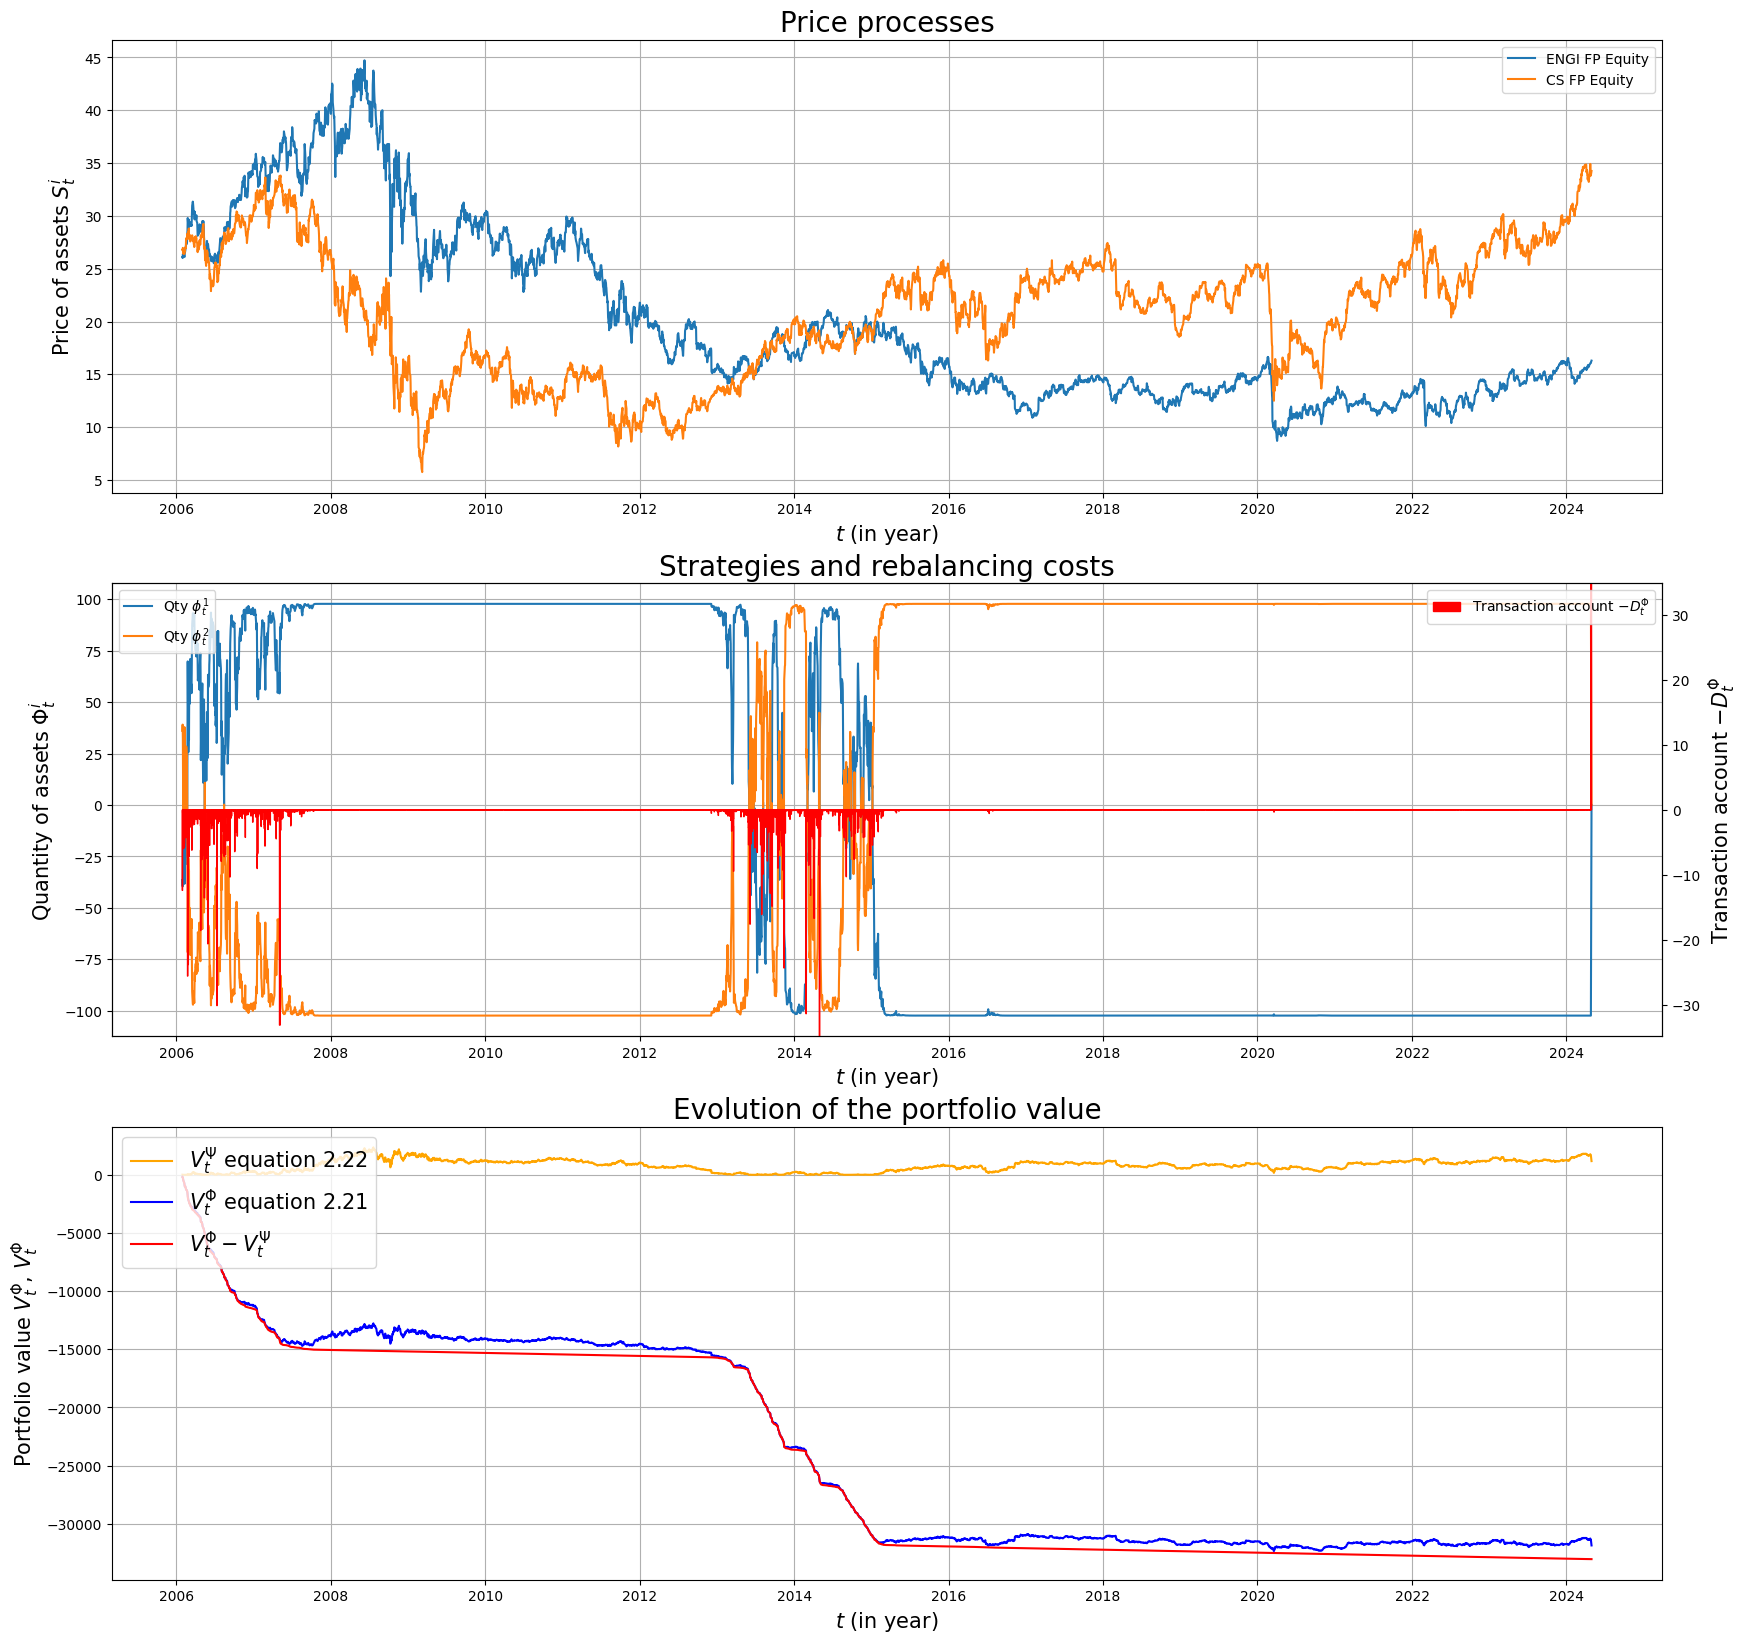

In [21]:
_, ax = plt.subplots(3, 1, figsize=(20, 20))
for col in df_ptf.columns:
    ax[0].plot(
        df_ptf[col],
        label=f"{col}",
    )

ax[0].set_xlabel("$t$ (in year)", fontsize=15)
ax[0].set_ylabel("Price of assets $S_t^i$", fontsize=15)
ax[0].set_title(f"Price processes", fontsize=20)
ax[0].grid()
ax[0].legend(fontsize=10)

for col in weights_df.columns:
    ax[1].plot(
        weights_df[col],
        label=r"Qty $\{}_t$".format(col.replace("_", "^")),
    )
ax_l = ax[1].twinx()
ax_l.fill_between(
    df_ptf.index,
    -transaction_account,
    color="red",
    step="pre",
    label=r"Transaction account $-D_t^\Phi$",
)

ax[1].set_xlabel("$t$ (in year)", fontsize=15)
ax[1].set_ylabel(r"Quantity of assets $\Phi_t^i$", fontsize=15)
ax_l.set_ylabel(r"Transaction account $-D_t^\Phi$", fontsize=15)
ax_l.set_ylim([-max(transaction_account), max(transaction_account)])
ax[1].set_title(f"Strategies and rebalancing costs", fontsize=20)
ax[1].grid()
ax[1].legend(fontsize=10, loc="upper left")
ax_l.legend(fontsize=10, loc="upper right")
# ax_l2 = ax[2].twinx()
ax[2].plot(df_ptf.index, V_t_psi, label=r"$V_t^\Psi$ equation 2.22", color="orange")
ax[2].plot(
    df_ptf.index,
    V_t_phi,
    # linestyle="--",
    label=r"$V_t^\Phi$ equation 2.21",
    color="blue",
)
ax[2].plot(
    df_ptf.index,
    V_t_phi - V_t_psi,
    label=r"$V_t^\Phi-V_t^\Psi$",
    color="red",
)

ax[2].set_xlabel("$t$ (in year)", fontsize=15)
ax[2].set_ylabel(r"Portfolio value $V_t^\Phi$, $V_t^\Phi$", fontsize=15)
ax[2].set_title(f"Evolution of the portfolio value", fontsize=20)
ax[2].grid()
# ax_l2.legend(fontsize=15, loc="upper left")
ax[2].legend(fontsize=15, loc="upper left")

# Idées

- Vol sto
- Données réelles avec exposant de Hurst cross section
  $$\hat{H}=-\frac{1}{2log(2)}log(\frac{1}{2}\frac{\sum_{i=0}^{N-1}(B_H((i+1)/N)-B_H(i/N))^2}{\sum_{i=0}^{(N/2)-1}(B_H(2(i+1)/N)-B_H(2i/N))^2})$$
- Prouver arbitrage pourquoi H>0.5 fonctionne et pas H=0.5 (dominance sto ?)
-


# Fourier sur fBm

Generating 2 fBm with different $H$ in order to analyze their frequency spectrum.


In [13]:
t, s_t_trendy = generate_brownian_path(
    n_steps=250, T=1, H=0.8, mu=0.15, sigma=0.2, s0=100, brownian_type="fractional"
)


t, s_t_meanrevert = generate_brownian_path(
    n_steps=250, T=1, H=0.2, mu=0.15, sigma=0.2, s0=100, brownian_type="fractional"
)

In [14]:
fft_meanrevert = np.fft.rfft(s_t_meanrevert)  # Frequency amplitude
fft_trendy = np.fft.rfft(s_t_trendy)  # Frequency amplitude

fft_frequencies = np.fft.rfftfreq(
    n=s_t_trendy.shape[0], d=1 / (252)
)  # Corresponding frequencies

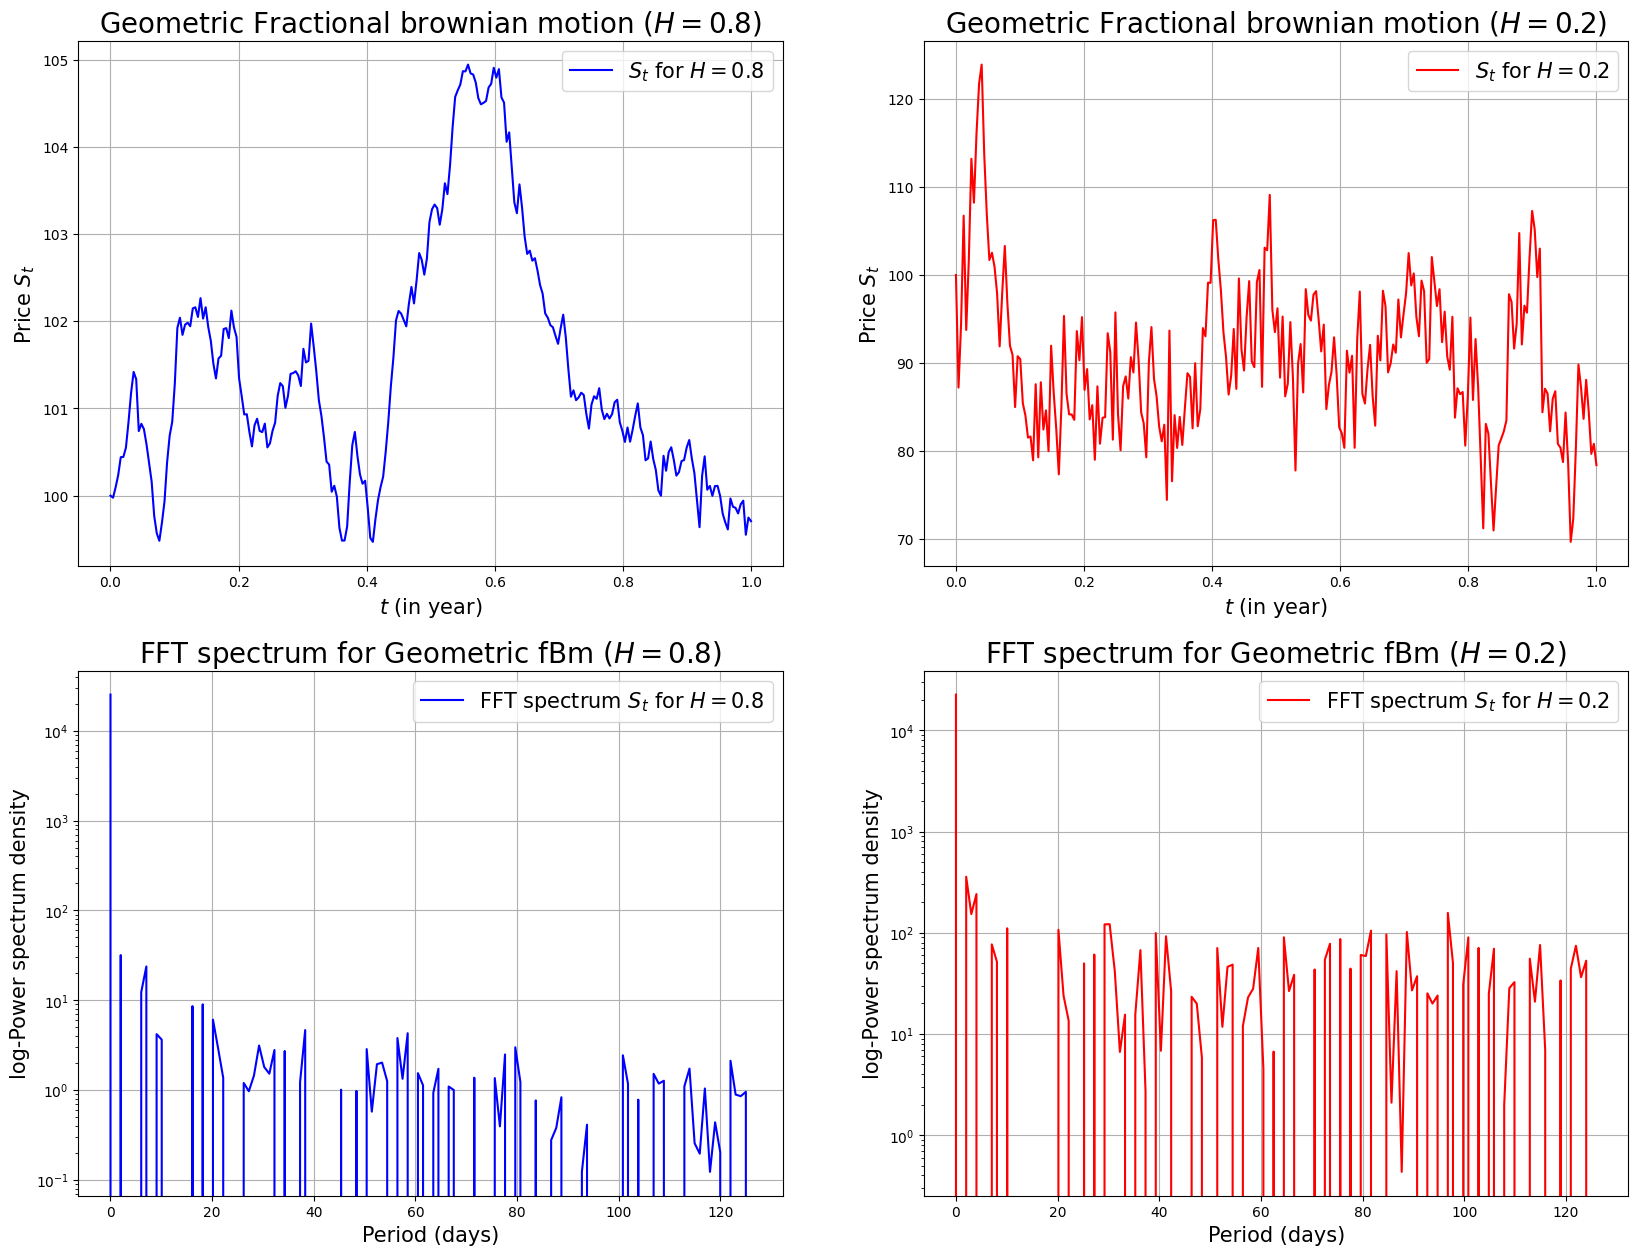

In [15]:
_, (ax1, ax2) = plt.subplots(2, 2, figsize=(20, 15))


ax1[0].plot(
    t,

    s_t_trendy,
    color="blue",
    label="$S_t$ for $H=0.8$",
)



ax1[0].set_xlabel("$t$ (in year)", fontsize=15)



ax1[0].set_ylabel("Price $S_t$", fontsize=15)



ax1[0].set_title(f"Geometric Fractional brownian motion ($H=0.8$)", fontsize=20)



ax1[0].grid()



ax1[0].legend(fontsize=15)



ax1[1].plot(
    t,

    s_t_meanrevert,
    color="red",

    label="$S_t$ for $H=0.2$",
)



ax1[1].set_xlabel("$t$ (in year)", fontsize=15)



ax1[1].set_ylabel("Price $S_t$", fontsize=15)



ax1[1].set_title(f"Geometric Fractional brownian motion ($H=0.2$)", fontsize=20)



ax1[1].grid()



ax1[1].legend(fontsize=15)



ax2[0].plot(
    fft_frequencies,
    fft_trendy.real,
    color="blue",
    label="FFT spectrum $S_t$ for $H=0.8$",
)



ax2[0].set_xlabel("Period (days)", fontsize=15)
ax2[0].set_ylabel("log-Power spectrum density", fontsize=15)
ax2[0].set_title(f"FFT spectrum for Geometric fBm ($H=0.8$)", fontsize=20)
ax2[0].grid()
ax2[0].set_yscale("log")
ax2[0].legend(fontsize=15)
ax2[1].plot(
    fft_frequencies,
    fft_meanrevert.real,
    color="red",
    label="FFT spectrum $S_t$ for $H=0.2$",
)



ax2[1].set_xlabel("Period (days)", fontsize=15)
ax2[1].set_ylabel("log-Power spectrum density", fontsize=15)
ax2[1].set_title(f"FFT spectrum for Geometric fBm ($H=0.2$)", fontsize=20)
ax2[1].grid()
ax2[1].set_yscale("log")
ax2[1].legend(fontsize=15)